In [1]:
from google.colab import drive
drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


**https://appliedmachinelearning.blog/2018/11/28/demonstration-of-facial-emotion-recognition-on-real-time-video-using-cnn-python-keras/**


In [2]:
import pandas as pd
import cv2
import numpy as np
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.layers import Activation, Convolution2D, Dropout, Conv2D
from keras.layers import AveragePooling2D, BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.models import Sequential
from keras.layers import Flatten
from keras.models import Model
from keras.layers import Input
from keras.layers import MaxPooling2D
from keras.layers import SeparableConv2D
from keras import layers
from keras.regularizers import l2
import pandas as pd
import cv2
import numpy as np

Using TensorFlow backend.


In [3]:
dataset_path = '/content/gdrive/My Drive/app/FacialEmotionRecognition/fer2013/fer2013.csv'
image_size=(48,48)
 
def load_fer2013():
    data = pd.read_csv(dataset_path)
    pixels = data['pixels'].tolist()
    width, height = 48, 48
    faces = []
    for pixel_sequence in pixels:
        face = [int(pixel) for pixel in pixel_sequence.split(' ')]
        face = np.asarray(face).reshape(width, height)
        face = cv2.resize(face.astype('uint8'),image_size)
        faces.append(face.astype('float32'))
    faces = np.asarray(faces)
    faces = np.expand_dims(faces, -1)
    emotions = pd.get_dummies(data['emotion']).as_matrix()
    return faces, emotions
 
def preprocess_input(x, v2=True):
    x = x.astype('float32')
    x = x / 255.0
    if v2:
        x = x - 0.5
        x = x * 2.0
    return x
 
faces, emotions = load_fer2013()
faces = preprocess_input(faces)
xtrain, xtest,ytrain,ytest = train_test_split(faces, emotions,test_size=0.2,shuffle=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()


In [0]:
print(faces)

In [6]:
# parameters
batch_size = 32
num_epochs = 110
input_shape = (48, 48, 1)
verbose = 1
num_classes = 7
patience = 50
base_path = '/content/gdrive/My Drive/app/FacialEmotionRecognition/'
l2_regularization=0.01
 
# data generator
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)
 
# model parameters
regularization = l2(l2_regularization)
 
# base
img_input = Input(input_shape)
x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization, use_bias=False)(img_input)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
 
# module 1
residual = Conv2D(16, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x = SeparableConv2D(16, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(16, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])
 
# module 2
residual = Conv2D(32, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x = SeparableConv2D(32, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(32, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])
 
# module 3
residual = Conv2D(64, (1, 1), strides=(2, 2),padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x = SeparableConv2D(64, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(64, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])
 
# module 4
residual = Conv2D(128, (1, 1), strides=(2, 2),padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x = SeparableConv2D(128, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(128, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])
x = Conv2D(num_classes, (3, 3), padding='same')(x)
x = GlobalAveragePooling2D()(x)
output = Activation('softmax',name='predictions')(x)
 
model = Model(img_input, output)
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()
 
# callbacks
log_file_path = base_path + '_emotion_training.log'
csv_logger = CSVLogger(log_file_path, append=False)
early_stop = EarlyStopping('val_loss', patience=patience)
reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1, patience=int(patience/4), verbose=1)
trained_models_path = base_path + '_mini_XCEPTION'
model_names = trained_models_path + '.{epoch:02d}-{val_acc:.2f}.hdf5'
model_checkpoint = ModelCheckpoint(model_names, 'val_loss', verbose=1,save_best_only=True)
callbacks = [model_checkpoint, csv_logger, early_stop, reduce_lr]
 
model.fit_generator(data_generator.flow(xtrain, ytrain,batch_size),
                        steps_per_epoch=len(xtrain) / batch_size,
                        epochs=num_epochs, verbose=1, callbacks=callbacks,
                        validation_data=(xtest,ytest))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 48, 48, 1)    0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 46, 46, 8)    72          input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_15 (BatchNo (None, 46, 46, 8)    32          conv2d_8[0][0]                   
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 46, 46, 8)    0           batch_normalization_15[0][0]     
__________________________________________________________________________________________________
conv2d_9 (

KeyboardInterrupt: ignored

/content/gdrive/My Drive/app/FacialEmotionRecognition/happy.jpg


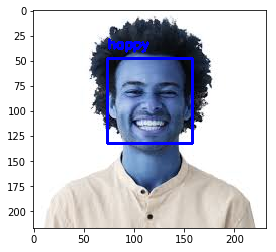

In [21]:
from keras.preprocessing.image import img_to_array
from keras.models import load_model
import imutils
import cv2
import numpy as np
import sys
import matplotlib.pyplot as plt
 
# parameters for loading data and images
detection_model_path = '/content/gdrive/My Drive/app/FacialEmotionRecognition/haarcascades/haarcascade_frontalface_default.xml'
emotion_model_path = '/content/gdrive/My Drive/app/FacialEmotionRecognition/_mini_XCEPTION.33-0.61.hdf5'
#img_path = sys.argv[1]

# hyper-parameters for bounding boxes shape
# loading models
face_detection = cv2.CascadeClassifier(detection_model_path)
emotion_classifier = load_model(emotion_model_path, compile=False)
EMOTIONS = ["angry","disgust","scared", "happy", "sad", "surprised","neutral"]

def test(img_path):
  print(img_path)
  #reading the frame
  orig_frame = cv2.imread(img_path)
  frame = cv2.imread(img_path,0)
  faces = face_detection.detectMultiScale(frame,scaleFactor=1.1,minNeighbors=5,minSize=(30,30),flags=cv2.CASCADE_SCALE_IMAGE)

  if len(faces) > 0:
      faces = sorted(faces, reverse=True,key=lambda x: (x[2] - x[0]) * (x[3] - x[1]))[0]
      (fX, fY, fW, fH) = faces
      roi = frame[fY:fY + fH, fX:fX + fW]
      roi = cv2.resize(roi, (48, 48))
      roi = roi.astype("float") / 255.0
      roi = img_to_array(roi)
      roi = np.expand_dims(roi, axis=0)
      preds = emotion_classifier.predict(roi)[0]
      emotion_probability = np.max(preds)
      label = EMOTIONS[preds.argmax()]
      cv2.putText(orig_frame, label, (fX, fY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
      cv2.rectangle(orig_frame, (fX, fY), (fX + fW, fY + fH),(0, 0, 255), 2)
      


  plt.imshow(orig_frame)

img_path = '/content/gdrive/My Drive/app/FacialEmotionRecognition/happy.jpg'
test(img_path)
plt.savefig('/content/gdrive/My Drive/app/FacialEmotionRecognition/test1.png')

/content/gdrive/My Drive/app/FacialEmotionRecognition/happy1.jpg


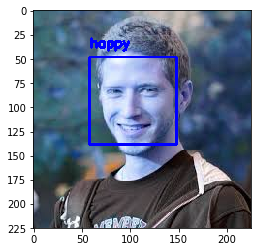

In [15]:
img_path = '/content/gdrive/My Drive/app/FacialEmotionRecognition/happy1.jpg'
test(img_path)

/content/gdrive/My Drive/app/FacialEmotionRecognition/angy.jpg


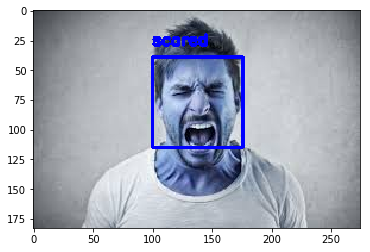

In [16]:
img_path = '/content/gdrive/My Drive/app/FacialEmotionRecognition/angy.jpg'
test(img_path)

/content/gdrive/My Drive/app/FacialEmotionRecognition/angy1.jpg


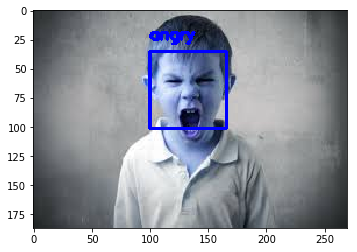

In [17]:
img_path = '/content/gdrive/My Drive/app/FacialEmotionRecognition/angy1.jpg'
test(img_path)

/content/gdrive/My Drive/app/FacialEmotionRecognition/sad.jpg


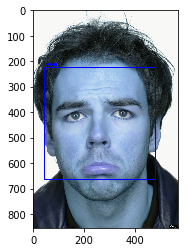

In [19]:
img_path = '/content/gdrive/My Drive/app/FacialEmotionRecognition/sad.jpg'
test(img_path)

/content/gdrive/My Drive/app/FacialEmotionRecognition/sad1.jpg


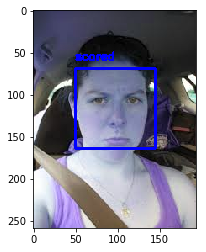

In [20]:
img_path = '/content/gdrive/My Drive/app/FacialEmotionRecognition/sad1.jpg'
test(img_path)